In [1]:
# Do the library imports
import pandas as pd
import os
import numpy as np

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# set path
os.chdir(r'D:\subFinder')

In [4]:
# os.getcwd()

In [5]:
# read in the PUL data from dbcan-PUL
pul_data = pd.read_csv(r"Data/Supervised_Sequences/updated_data_filtered.csv")

In [6]:
pul_data = pul_data.sort_values("PULid")

In [7]:
pul_data = pul_data.reset_index(drop = True)

In [8]:
# pul_data

In [9]:
# path where IFDP predictions are
path = r"D:\subFinder\IFDP_sub\PUL\substrate_out"

In [10]:
# loop over IFDP predictions
catch = []
catch_no_preds = []
for item in os.listdir(path):
    # get the PUL
    pulid = item.split(".")[0]
    # read the csv file
    df = pd.read_csv(path + "\\" + item)
    # find the max abundance
    max_abundance = df["Relative abundance"].max()
    # if there is no max abundance
    # keep that pul id
    if np.isnan(max_abundance):
        catch_no_preds.append(pulid)  
    
    # get the substrates corresponding to the max abundance
    pred_substrates = df[df["Relative abundance"] == max_abundance]
    # get the substrate column
    sub_preds = pred_substrates.iloc[:,0]
    sub_preds = pd.DataFrame(sub_preds)
    sub_preds["PULid"] = pulid
    catch.append(sub_preds)

In [11]:
sub_preds

,Unnamed: 0,PULid
15,Xylan,PUL0602
16,Arabinoxylan,PUL0602


In [12]:
# How many PULs with no substrate
len(catch_no_preds)

105

In [13]:
# convert to a dataframe
catch_df = pd.concat(catch)

In [14]:
# take a glimpse
catch_df.head()

,Unnamed: 0,PULid
16,Arabinoxylan,PUL
0,Xanthan,PUL0001
0,Xanthan,PUL0002
1,Beta-glucan,PUL0002
2,Cellulose,PUL0002


In [15]:
# give descriptive names
catch_df.columns = ["IFDP_high_level_substr", "PULid"]

In [16]:
# lowercase the substrates
catch_df["IFDP_high_level_substr"] = catch_df["IFDP_high_level_substr"].str.lower()

In [17]:
# how much is the coverage of substrates in correspondence with dbcan-PUL
len(set(pul_data["PULid"]).intersection(catch_df["PULid"]))/pul_data["PULid"].nunique()

0.7177615571776156

In [18]:
# how many puls from dbcan-pul do not have IFDP predictions
len(set(pul_data["PULid"]).difference(catch_df["PULid"]))

116

In [19]:
# catch_df["IFDP_high_level_substr"].value_counts()

In [20]:
# handle the mannan edge case
pul_data = pul_data.replace(['beta-mannan', 'alpha-mannan'], 'mannan')

In [21]:
## read in the substrate mapping file
sub_mapping = pd.read_excel(r"D:\subFinder\IFDP_sub\substrate_mapping_table_IFDP_dbCAN.xlsx")

In [22]:
sub_mapping["Substrate_dbCAN_seq_dbCAN_PUL_approach"] = sub_mapping["Substrate_dbCAN_seq_dbCAN_PUL_approach"].map(lambda x: str(x).split("/")[0])

In [23]:
sub_mapping["Substrate_IFDP"] = sub_mapping["Substrate_IFDP"].str.lower()

In [24]:
sub_mapping = sub_mapping[sub_mapping["Substrate_dbCAN_seq_dbCAN_PUL_approach"] != "nan"]

In [25]:
sub_mapping = sub_mapping.iloc[:,[0,2]]

In [26]:
# handle mannan edge case in the mapping table
sub_mapping = sub_mapping.replace(['alpha-mannan&beta-mannan'], 'mannan')

In [27]:
sub_mapping.head()

,Substrate_dbCAN_seq_dbCAN_PUL_approach,Substrate_IFDP
0,alginate,alginate
1,arabinan,arabinan
2,arabinogalactan,arabinogalactan
3,arabinoxylan,arabinoxylan
4,beta-glucan,beta-glucan


In [28]:
catch_df = catch_df.merge(pul_data[["PULid", "high_level_substr"]])

In [29]:
catch_df.columns = ["IFDP_high_level_substr", "PULid", "Verified_high_level_substr"]

In [30]:
catch_df = catch_df[["PULid", "Verified_high_level_substr", "IFDP_high_level_substr"]]

In [31]:
catch_df.head()

,PULid,Verified_high_level_substr,IFDP_high_level_substr
0,PUL0001,mannan,xanthan
1,PUL0002,beta-glucan,xanthan
2,PUL0002,beta-glucan,beta-glucan
3,PUL0002,beta-glucan,cellulose
4,PUL0002,beta-glucan,xloglucan


In [32]:
np.mean(catch_df["IFDP_high_level_substr"] == catch_df["Verified_high_level_substr"])

0.1292517006802721

In [33]:
# do a join to map IFDP substrates using substrate mapping table
catch_df = catch_df.merge(sub_mapping, left_on = "IFDP_high_level_substr", right_on = "Substrate_IFDP", how = "inner")

In [34]:
# you can see we have the corresponding substrate names from dbcan mapped to ifdp
catch_df.head()

,PULid,Verified_high_level_substr,IFDP_high_level_substr,Substrate_dbCAN_seq_dbCAN_PUL_approach,Substrate_IFDP
0,PUL0002,beta-glucan,beta-glucan,beta-glucan,beta-glucan
1,PUL0009,glycosaminoglycan,beta-glucan,beta-glucan,beta-glucan
2,PUL0011,cellulose,beta-glucan,beta-glucan,beta-glucan
3,PUL0012,chitin,beta-glucan,beta-glucan,beta-glucan
4,PUL0024,fructan,beta-glucan,beta-glucan,beta-glucan


In [35]:
np.mean(catch_df["IFDP_high_level_substr"] == catch_df["Substrate_IFDP"])

1.0

In [36]:
catch_df.columns = ['PULid', 'Verified_high_level_substr', 'IFDP_Predicted_high_level_substr', 'IFDP_Predicted_high_level_substr_dbcan_taxonomy', 'IFDP_Predicted_high_level_substr_IFDP_taxonomy']

In [37]:
np.mean(catch_df['IFDP_Predicted_high_level_substr_dbcan_taxonomy'] == catch_df['Verified_high_level_substr'])

0.22535211267605634

In [38]:
# catch_df["PULid"].nunique()

In [39]:
# catch_df = catch_df[["Substrate_dbCAN_seq_dbCAN_PUL_approach", "PULid"]]

In [40]:
# catch_df.columns = ["Verified_high_level_substr", "PULid"]

In [41]:
# merged_data = pul_data[["PULid", "high_level_substr"]].merge(catch_df)

In [42]:
# merged_data.columns = ["PULid","Verified_high_level_substr", "IFDP_high_level_substr"]

In [43]:
# merged_data["IFDP_high_level_substr"] = merged_data["IFDP_high_level_substr"].str.lower()

In [44]:
catch_df["Verified_high_level_substr"].sort_values().unique()

array(['agarose', 'alginate', 'alpha-glucan', 'arabinan',
       'arabinogalactan', 'arabinoxylan', 'beta-galactooligosaccharide',
       'beta-glucan', 'capsule polysaccharide degradation',
       'capsule polysaccharide synthesis', 'carrageenan', 'cellulose',
       'chitin', 'fructan', 'galactan', 'galactomannan', 'glucomannan',
       'glycogen', 'glycosaminoglycan', 'host glycan', 'mannan', 'pectin',
       'starch', 'xylan', 'xyloglucan'], dtype=object)

In [45]:
catch_df['IFDP_Predicted_high_level_substr_dbcan_taxonomy'].sort_values().unique()

array(['alginate', 'arabinan', 'arabinogalactan', 'arabinoxylan',
       'beta-glucan', 'carrageenan', 'cellulose', 'chitin', 'fructan',
       'galactan', 'galactomannan', 'glucomannan', 'host glycan',
       'mannan', 'pectin', 'starch', 'xylan', 'xyloglucan'], dtype=object)

In [46]:
common = set(catch_df["Verified_high_level_substr"].sort_values().unique()).intersection(catch_df["IFDP_Predicted_high_level_substr_dbcan_taxonomy"].sort_values().unique())

In [47]:
common

{'alginate',
 'arabinan',
 'arabinogalactan',
 'arabinoxylan',
 'beta-glucan',
 'carrageenan',
 'cellulose',
 'chitin',
 'fructan',
 'galactan',
 'galactomannan',
 'glucomannan',
 'host glycan',
 'mannan',
 'pectin',
 'starch',
 'xylan',
 'xyloglucan'}

In [48]:
len(common)

18

In [49]:
len(common)/len(catch_df["Verified_high_level_substr"].sort_values().unique())

0.72

In [50]:
uncommon = set(catch_df["Verified_high_level_substr"].sort_values().unique()).difference(catch_df["IFDP_Predicted_high_level_substr_dbcan_taxonomy"].sort_values().unique())

In [51]:
uncommon

{'agarose',
 'alpha-glucan',
 'beta-galactooligosaccharide',
 'capsule polysaccharide degradation',
 'capsule polysaccharide synthesis',
 'glycogen',
 'glycosaminoglycan'}

In [52]:
len(uncommon)

7

In [53]:
merged_data_common = catch_df[catch_df["Verified_high_level_substr"].isin(common)]

In [54]:
merged_data_common["PULid"].nunique()

215

In [55]:
pul_data["PULid"].nunique()

411

In [56]:
merged_data_uncommon = catch_df[catch_df["Verified_high_level_substr"].isin(uncommon)]

In [57]:
merged_data_uncommon["PULid"].nunique()

69

In [58]:
merged_data_common["PULid"].nunique()/pul_data["PULid"].nunique()

0.5231143552311436

In [59]:
number_of_preds = merged_data_common["PULid"].value_counts()

In [60]:
number_of_preds = number_of_preds.reset_index()

In [61]:
number_of_preds.columns = ["PULid", "Num_Preds_from_IFDP"]

In [62]:
how_many_preds = number_of_preds["Num_Preds_from_IFDP"].value_counts()

In [63]:
how_many_preds = how_many_preds.reset_index()

In [64]:
how_many_preds.columns = ["Num_Preds_from_IFDP", "Number_of_PULs"]

In [65]:
how_many_preds[how_many_preds["Num_Preds_from_IFDP"] == 1]["Number_of_PULs"].values[0]/how_many_preds["Number_of_PULs"].sum()

0.4883720930232558

In [66]:
how_many_preds[how_many_preds["Num_Preds_from_IFDP"] == 1]["Number_of_PULs"].values[0]/merged_data_common["PULid"].nunique()

0.4883720930232558

In [67]:
how_many_preds[how_many_preds["Num_Preds_from_IFDP"] == 1]["Number_of_PULs"].values[0]

105

In [68]:
merged_data_common["PULid"].nunique()

215

In [69]:
105/215

0.4883720930232558

In [70]:
# 206/411

In [71]:
import matplotlib.pyplot as plt

In [72]:
# 148-54

In [73]:
215-105

110

In [74]:
1-(105/215)

0.5116279069767442

In [75]:
order = how_many_preds["Num_Preds_from_IFDP"].sort_values().values

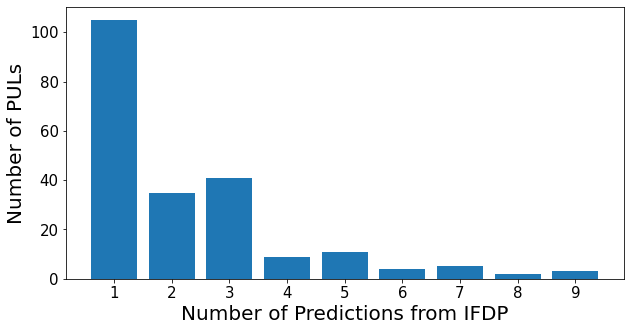

In [76]:
plt.figure(figsize = (10,5))
plt.bar(how_many_preds["Num_Preds_from_IFDP"], how_many_preds["Number_of_PULs"])
plt.xticks(order, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Number of Predictions from IFDP", fontsize = 20)
plt.ylabel("Number of PULs", fontsize = 20)
# plt.title("IFDP makes multiple predictions for ")
plt.show()

In [77]:
puls_with_single_preds = number_of_preds[number_of_preds["Num_Preds_from_IFDP"] == 1]["PULid"].values

In [78]:
puls_with_single_preds_df = merged_data_common[merged_data_common["PULid"].isin(puls_with_single_preds)]

In [79]:
puls_with_single_preds_df.head()

,PULid,Verified_high_level_substr,IFDP_Predicted_high_level_substr,IFDP_Predicted_high_level_substr_dbcan_taxonomy,IFDP_Predicted_high_level_substr_IFDP_taxonomy
17,PUL0220,beta-glucan,beta-glucan,beta-glucan,beta-glucan
33,PUL0325,beta-glucan,beta-glucan,beta-glucan,beta-glucan
39,PUL0401,beta-glucan,beta-glucan,beta-glucan,beta-glucan
42,PUL0406,beta-glucan,beta-glucan,beta-glucan,beta-glucan
47,PUL0477,beta-glucan,beta-glucan,beta-glucan,beta-glucan


In [80]:
puls_with_single_preds_df.shape

(105, 5)

In [81]:
puls_with_single_preds_df["IFDP_Predicted_high_level_substr_dbcan_taxonomy"].value_counts()

chitin             17
arabinoxylan       16
starch             15
xyloglucan         14
alginate           14
beta-glucan         7
carrageenan         6
fructan             6
galactomannan       5
arabinogalactan     4
pectin              1
Name: IFDP_Predicted_high_level_substr_dbcan_taxonomy, dtype: int64

In [82]:
# puls_with_single_preds_df["PULid"].values

In [83]:
# pul_data["high_level_substr"].value_counts()

In [84]:
single_preds_puls = puls_with_single_preds_df["PULid"].values

In [85]:
single_pred_og_data = pul_data[pul_data["PULid"].isin(puls_with_single_preds_df["PULid"].values)]["high_level_substr"].value_counts()

In [86]:
puls_with_single_preds_df

,PULid,Verified_high_level_substr,IFDP_Predicted_high_level_substr,IFDP_Predicted_high_level_substr_dbcan_taxonomy,IFDP_Predicted_high_level_substr_IFDP_taxonomy
17,PUL0220,beta-glucan,beta-glucan,beta-glucan,beta-glucan
33,PUL0325,beta-glucan,beta-glucan,beta-glucan,beta-glucan
39,PUL0401,beta-glucan,beta-glucan,beta-glucan,beta-glucan
42,PUL0406,beta-glucan,beta-glucan,beta-glucan,beta-glucan
47,PUL0477,beta-glucan,beta-glucan,beta-glucan,beta-glucan
...,...,...,...,...,...
588,PUL0030,galactomannan,galctomannan,galactomannan,galctomannan
591,PUL0167,mannan,galctomannan,galactomannan,galctomannan
593,PUL0175,galactomannan,galctomannan,galactomannan,galctomannan
594,PUL0178,galactomannan,galctomannan,galactomannan,galctomannan


In [87]:
np.mean(puls_with_single_preds_df["Verified_high_level_substr"] == puls_with_single_preds_df["IFDP_Predicted_high_level_substr_dbcan_taxonomy"])

0.580952380952381

In [88]:
pul_left_data = pul_data[~pul_data["PULid"].isin(single_preds_puls)]

In [89]:
pul_left_data.shape

(306, 4)

In [90]:
single_pred_og_data

alginate           14
host glycan        12
starch             12
chitin              9
galactomannan       8
mannan              8
xyloglucan          6
xylan               6
fructan             5
carrageenan         5
pectin              5
beta-glucan         5
arabinan            3
cellulose           2
arabinogalactan     2
arabinoxylan        1
galactan            1
glucomannan         1
Name: high_level_substr, dtype: int64

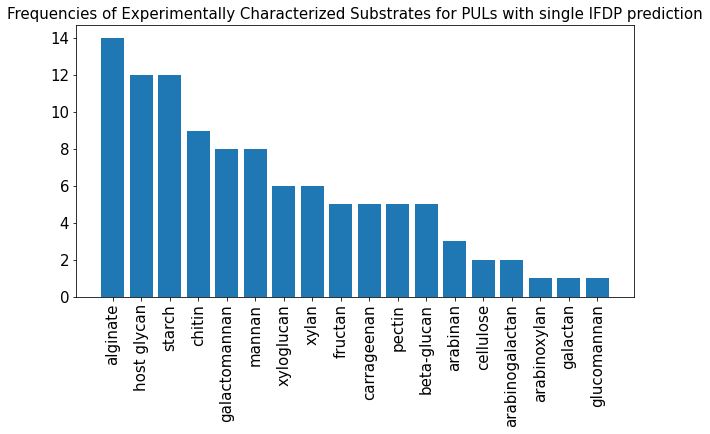

In [91]:
plt.figure(figsize = (10,5))
plt.bar(single_pred_og_data.reset_index()["index"], single_pred_og_data.reset_index()["high_level_substr"])
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Frequencies of Experimentally Characterized Substrates for PULs with single IFDP prediction", fontsize = 15)
plt.show()

In [92]:
left_freqs = pul_left_data["high_level_substr"].value_counts()

In [93]:
left_to_keep = left_freqs[left_freqs.index.isin(single_pred_og_data.index)]

In [94]:
left_to_keep

pectin             34
xylan              29
beta-glucan        16
cellulose          14
galactan            9
arabinan            9
mannan              8
galactomannan       7
alginate            7
host glycan         7
chitin              6
arabinoxylan        5
starch              4
carrageenan         3
arabinogalactan     3
fructan             2
glucomannan         2
xyloglucan          1
Name: high_level_substr, dtype: int64

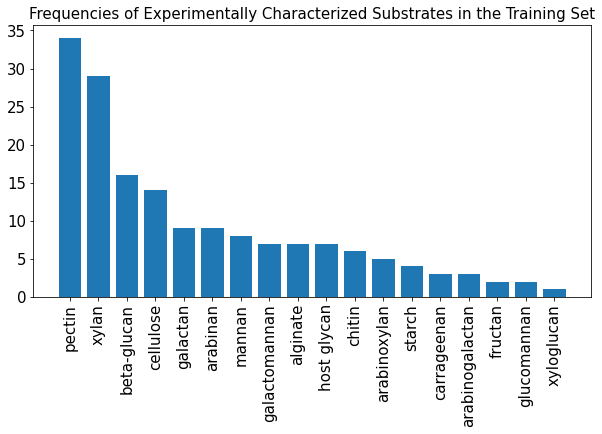

In [95]:
plt.figure(figsize = (10,5))
plt.bar(left_to_keep.reset_index()["index"], left_to_keep.reset_index()["high_level_substr"])
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Frequencies of Experimentally Characterized Substrates in the Training Set", fontsize = 15)
plt.show()

In [96]:
new_order = list(left_to_keep.iloc[:10].index)

In [97]:
new_order

['pectin',
 'xylan',
 'beta-glucan',
 'cellulose',
 'galactan',
 'arabinan',
 'mannan',
 'galactomannan',
 'alginate',
 'host glycan']

In [98]:
single_pred_og_data

alginate           14
host glycan        12
starch             12
chitin              9
galactomannan       8
mannan              8
xyloglucan          6
xylan               6
fructan             5
carrageenan         5
pectin              5
beta-glucan         5
arabinan            3
cellulose           2
arabinogalactan     2
arabinoxylan        1
galactan            1
glucomannan         1
Name: high_level_substr, dtype: int64

In [99]:
single_pred_og_data_test = single_pred_og_data.reset_index()[single_pred_og_data.reset_index()["index"].isin(new_order)]

In [100]:
single_pred_og_data_test

,index,high_level_substr
0,alginate,14
1,host glycan,12
4,galactomannan,8
5,mannan,8
7,xylan,6
10,pectin,5
11,beta-glucan,5
12,arabinan,3
13,cellulose,2
16,galactan,1


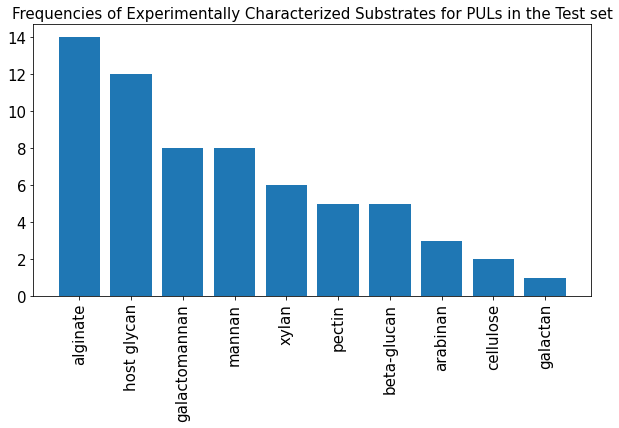

In [101]:
plt.figure(figsize = (10,5))
plt.bar(single_pred_og_data_test["index"], single_pred_og_data_test["high_level_substr"])
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Frequencies of Experimentally Characterized Substrates for PULs in the Test set", fontsize = 15)
plt.show()

In [102]:
test_set = puls_with_single_preds_df[puls_with_single_preds_df["Verified_high_level_substr"].isin(new_order)]

In [103]:
test_set_puls = test_set["PULid"].values

In [104]:
X_test = pul_data[pul_data["PULid"].isin(test_set_puls)]["sig_gene_seq"]

In [105]:
y_test = pul_data[pul_data["PULid"].isin(test_set_puls)]["high_level_substr"].values

In [106]:
y_test

array(['xylan', 'xylan', 'arabinan', 'alginate', 'galactomannan',
       'alginate', 'alginate', 'alginate', 'alginate', 'alginate',
       'alginate', 'cellulose', 'host glycan', 'host glycan', 'arabinan',
       'alginate', 'alginate', 'alginate', 'mannan', 'mannan', 'mannan',
       'mannan', 'host glycan', 'galactomannan', 'galactomannan',
       'galactomannan', 'pectin', 'host glycan', 'alginate',
       'host glycan', 'host glycan', 'host glycan', 'galactomannan',
       'galactomannan', 'beta-glucan', 'host glycan', 'cellulose',
       'galactomannan', 'alginate', 'beta-glucan', 'xylan', 'xylan',
       'mannan', 'mannan', 'xylan', 'galactan', 'alginate', 'beta-glucan',
       'beta-glucan', 'host glycan', 'host glycan', 'host glycan',
       'beta-glucan', 'pectin', 'mannan', 'pectin', 'arabinan', 'xylan',
       'host glycan', 'mannan', 'pectin', 'pectin', 'alginate',
       'galactomannan'], dtype=object)

In [107]:
X_test.shape

(64,)

In [108]:
test_seqs = np.array([test_item.replace("|", ",").replace(",", " ") for test_item in X_test.values])

In [109]:
single_pred_og_data[single_pred_og_data.index.isin(new_order)].values.sum()

64

In [110]:
to_model_data = pul_left_data[pul_left_data["high_level_substr"].isin(new_order)]

In [111]:
to_model_data.shape

(140, 4)

In [112]:
to_model_data["high_level_substr"].value_counts()

pectin           34
xylan            29
beta-glucan      16
cellulose        14
galactan          9
arabinan          9
mannan            8
host glycan       7
alginate          7
galactomannan     7
Name: high_level_substr, dtype: int64

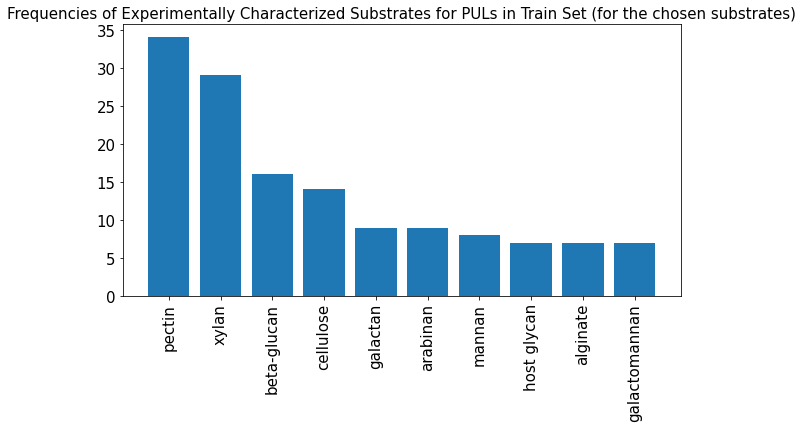

In [113]:
plt.figure(figsize = (10,5))
plt.bar(to_model_data["high_level_substr"].value_counts().reset_index()["index"], to_model_data["high_level_substr"].value_counts().reset_index()["high_level_substr"])
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Frequencies of Experimentally Characterized Substrates for PULs in Train Set (for the chosen substrates)", fontsize = 15)
plt.show()

In [114]:
from Codes.Model_architectures import simple_lstm, attention_lstm_model, non_recurrent_attention_model

In [115]:
import gensim

In [116]:
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_sg_vec_50") 

In [117]:
# model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_sg_vec_100") 

In [118]:
# import tensorflow as tf

In [119]:
def non_recurrent_attention_model(num_classes, training, model_cbow): 
    padding_vector = np.zeros((1, model_cbow.wv.vectors.shape[1]))
    unknown_vector = np.zeros((1, model_cbow.wv.vectors.shape[1]))
    weight_vectors = np.vstack((padding_vector, unknown_vector))
    weight_vectors = np.vstack((weight_vectors, model_cbow.wv.vectors))
    embedding_layer = tf.keras.layers.Embedding(len(weight_vectors),
                            weight_vectors.shape[1],
                            weights=[weight_vectors],
                            mask_zero = False,
                            trainable=False)
    
    vectorize_layer = tf.keras.layers.TextVectorization(
                     output_mode='int',
                     vocabulary=model_cbow.wv.index_to_key, 
                     standardize = None)
    input_layer = tf.keras.layers.Input(shape = (1,), dtype = tf.string)

    vectorize = vectorize_layer(input_layer)

    vectorize.shape

    emb_output = embedding_layer(vectorize)

    emb_output.shape

    x_a = tf.keras.layers.Dense(emb_output.get_shape()[-1]//2, kernel_initializer = 'glorot_uniform', activation="tanh", name="tanh_mlp")(emb_output) 
    
    x_a = tf.keras.layers.Dropout(0.5)(x_a, training = training)
    
    x_a = tf.keras.layers.Dense(1, kernel_initializer = 'glorot_uniform', activation='linear', name="word-level_context")(x_a)

    x_a = tf.keras.layers.Flatten()(x_a)

    att_out = tf.keras.layers.Activation('softmax')(x_a) 

    x_a2 = tf.keras.layers.RepeatVector(emb_output.get_shape()[-1])(att_out)

    x_a2 = tf.keras.layers.Permute([2,1])(x_a2)

    out = tf.keras.layers.Multiply()([emb_output,x_a2])
    
    out = tf.keras.layers.Lambda(lambda x : tf.math.reduce_sum(x, axis = 1), name='expectation_over_words')(out)

    dropout_layer = tf.keras.layers.Dropout(0.65)(out, training = training)

    pred_head = tf.keras.layers.Dense(num_classes)

    pred_output = pred_head(dropout_layer)

    model = tf.keras.models.Model(input_layer, pred_output)
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2), 
                 metrics= "accuracy")
    
    return model

In [120]:
model_dl = non_recurrent_attention_model(len(new_order), False, model_sg)

In [121]:
model_dl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, None, 50)     68800       ['text_vectorization[0][0]']     
                                                                                                  
 tanh_mlp (Dense)               (None, None, 25)     1275        ['embedding[0][0]']          

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
from sklearn.preprocessing import LabelEncoder

In [124]:
le = LabelEncoder()

In [125]:
X_train, X_valid, y_train, y_valid = train_test_split(to_model_data["sig_gene_seq"], to_model_data["high_level_substr"], 
                                                                  stratify = to_model_data["high_level_substr"],
                                                                  test_size = 0.10, random_state = 42)
            
train_seqs = np.array([train_item.replace("|", ",").replace(",", " ") for train_item in X_train])
valid_seqs = np.array([valid_item.replace("|", ",").replace(",", " ") for valid_item in X_valid])
# test_seqs = np.array([test_item.replace("|", ",").replace(",", " ") for test_item in X_test["sig_gene_seq"].values])

In [126]:
le.fit(y_train.values.reshape(-1,1).ravel())

LabelEncoder()

In [127]:
y_train = le.transform(y_train.values.reshape(-1,1).ravel())
            # y_train = y_train.toarray()
            
y_valid = le.transform(y_valid.values.reshape(-1,1).ravel())
            # y_valid = y_valid.toarray()
            
y_train_df = pd.DataFrame(y_train)
            
weights = y_train_df[0].value_counts()/y_train_df[0].value_counts().sum()
            
weights = 1/weights
            
# weights = 1/(y_train.sum(0)/y_train.sum(0).sum())
class_weights = dict(weights)

In [128]:
y_test = le.transform(y_test)

In [129]:
import tensorflow as tf

In [130]:
model_dl.fit(train_seqs, y_train, validation_data = (valid_seqs, y_valid), batch_size = 1, epochs = 2000, 
                                     callbacks  = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10,
                                                                                   restore_best_weights=True), 
                                     validation_batch_size=1, verbose = 1, shuffle = True, class_weight = class_weights)

Epoch 1/2000
126/126 [==============================] - 3s 14ms/step - loss: 20.2262 - accuracy: 0.3492 - val_loss: 1.1957 - val_accuracy: 0.7857
Epoch 2/2000
126/126 [==============================] - 1s 11ms/step - loss: 9.2610 - accuracy: 0.7698 - val_loss: 1.0006 - val_accuracy: 0.7143
Epoch 3/2000
126/126 [==============================] - 1s 10ms/step - loss: 6.4395 - accuracy: 0.8175 - val_loss: 1.0461 - val_accuracy: 0.7143
Epoch 4/2000
126/126 [==============================] - 1s 10ms/step - loss: 5.3413 - accuracy: 0.8571 - val_loss: 0.9675 - val_accuracy: 0.7857
Epoch 5/2000
126/126 [==============================] - 1s 10ms/step - loss: 4.1498 - accuracy: 0.8968 - val_loss: 1.0035 - val_accuracy: 0.7857
Epoch 6/2000
126/126 [==============================] - 1s 10ms/step - loss: 4.2472 - accuracy: 0.8889 - val_loss: 1.0106 - val_accuracy: 0.7857
Epoch 7/2000
126/126 [==============================] - 1s 10ms/step - loss: 3.5151 - accuracy: 0.9048 - val_loss: 1.0484 - val_a

In [131]:
model_dl.evaluate(valid_seqs, y_valid)

1/1 [==============================] - 0s 224ms/step - loss: 1.2016 - accuracy: 0.7857


[1.201589584350586, 0.7857142686843872]

In [132]:
model_dl.evaluate(test_seqs, y_test)

2/2 [==============================] - 0s 10ms/step - loss: 1.4699 - accuracy: 0.5312


[1.469853162765503, 0.53125]

In [133]:
y_test_pred = le.inverse_transform(model_dl.predict(test_seqs).argmax(1))

2/2 [==============================] - 0s 7ms/step


In [134]:
np.mean(le.inverse_transform(y_test) == y_test_pred)

0.53125

In [135]:
actual_subs = le.inverse_transform(y_test)

In [136]:
predicted_ifdp_subs = y_test_pred

In [137]:
common_order = set(actual_subs).union(predicted_ifdp_subs)

In [138]:
from sklearn.metrics import confusion_matrix

In [139]:
cm = confusion_matrix(actual_subs, predicted_ifdp_subs, normalize = "true", labels = list(common_order))

In [140]:
df_cm = pd.DataFrame(cm, index = list(common_order), columns= list(common_order))

In [141]:
import seaborn as sns

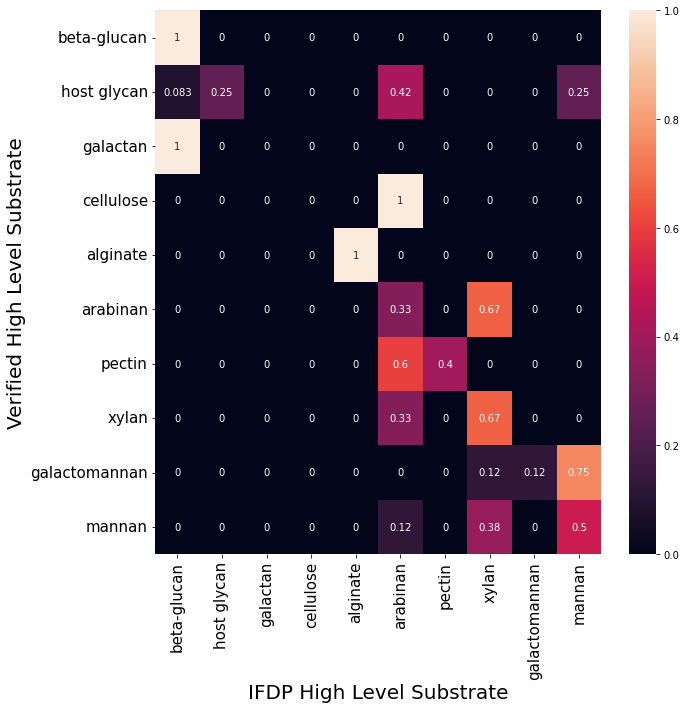

In [142]:
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15,  rotation = 0)
plt.ylabel("Verified High Level Substrate", fontsize = 20)
plt.xlabel("IFDP High Level Substrate", fontsize = 20)
plt.show()

In [143]:
np.mean(test_set["Verified_high_level_substr"] == test_set["IFDP_Predicted_high_level_substr_dbcan_taxonomy"])

0.359375

In [144]:
test_set.shape

(64, 5)

In [145]:
vec_size = model_sg.wv.vectors.shape[1]

In [146]:
X_train,  y_train = to_model_data["sig_gene_seq"], to_model_data["high_level_substr"].values

In [147]:
vocab = model_sg.wv.index_to_key
X_train_doc_vectors = []
    
for train_item in X_train.values:
    train_item = train_item.replace("|", ",").split(",")
    word_vectors = []
    for word in train_item: 
        if word in vocab:
            word_vectors.append(model_sg.wv.get_vector(word).reshape(1,-1).tolist()[0])
        else:
            word_vectors.append(np.zeros((1,vec_size)).reshape(1,-1).tolist()[0])
                
                
    if len(word_vectors) == 0: 
        X_train_doc_vectors.append(np.zeros((1,vec_size)).tolist()[0])
    else:
        X_train_doc_vectors.append(np.array(word_vectors).mean(0).tolist())    

In [148]:
# np.array(X_train_doc_vectors).shape

In [149]:
X_test_doc_vectors = []
    
for test_item in X_test.values:
    test_item = test_item.replace("|", ",").split(",")
    word_vectors = []
    for word in test_item: 
        if word in vocab:
            word_vectors.append(model_sg.wv.get_vector(word).reshape(1,-1).tolist()[0])
        else:
            word_vectors.append(np.zeros((1,vec_size)).reshape(1,-1).tolist()[0])
                        
    if len(word_vectors) == 0: 
        X_test_doc_vectors.append(np.zeros((1,vec_size)).tolist()[0])
    else:
        X_test_doc_vectors.append(np.array(word_vectors).mean(0).tolist())    
                

In [150]:
from sklearn.pipeline import Pipeline

In [151]:
from sklearn.multiclass import OneVsRestClassifier

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [154]:
parameters_one_vs_rest = {"vr__estimator__n_estimators": [100, 300, 500], 
                              "vr__estimator__class_weight": ["balanced"]}

In [155]:
clf_one_vs_rest = Pipeline([('vr', OneVsRestClassifier(BalancedRandomForestClassifier(n_jobs = 7, random_state = 84)))
                                                ])
gs_one_vs_rest = GridSearchCV(clf_one_vs_rest, parameters_one_vs_rest, cv = 5, n_jobs = 7, scoring = "balanced_accuracy", verbose = 0)

In [156]:
# parameters_one_vs_rest = {"vr__n_estimators": [100, 300, 500], 
#                               "vr__class_weight": ["balanced"]}

In [157]:
# clf_one_vs_rest = Pipeline([('vr', BalancedRandomForestClassifier(n_jobs = 7))
#                                                 ])
# gs_one_vs_rest = GridSearchCV(clf_one_vs_rest, parameters_one_vs_rest, cv = 5, n_jobs = 7, scoring = "balanced_accuracy", verbose = 0)

In [158]:
gs_one_vs_rest.fit(np.array(X_train_doc_vectors), y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vr',
                                        OneVsRestClassifier(estimator=BalancedRandomForestClassifier(n_jobs=7,
                                                                                                     random_state=84)))]),
             n_jobs=7,
             param_grid={'vr__estimator__class_weight': ['balanced'],
                         'vr__estimator__n_estimators': [100, 300, 500]},
             scoring='balanced_accuracy')

In [159]:
gs_one_vs_rest.best_score_

0.6614285714285715

In [160]:
gs_one_vs_rest.best_params_

{'vr__estimator__class_weight': 'balanced', 'vr__estimator__n_estimators': 300}

In [161]:
y_test_pred = gs_one_vs_rest.predict(np.array(X_test_doc_vectors))

In [162]:
y_test_pred

array(['host glycan', 'xylan', 'xylan', 'alginate', 'mannan', 'alginate',
       'alginate', 'alginate', 'alginate', 'alginate', 'alginate',
       'host glycan', 'host glycan', 'host glycan', 'arabinan',
       'alginate', 'alginate', 'alginate', 'host glycan', 'mannan',
       'mannan', 'mannan', 'host glycan', 'mannan', 'mannan',
       'host glycan', 'pectin', 'host glycan', 'alginate',
       'galactomannan', 'galactomannan', 'host glycan', 'galactomannan',
       'galactan', 'beta-glucan', 'mannan', 'arabinan', 'galactan',
       'alginate', 'beta-glucan', 'arabinan', 'xylan', 'mannan', 'mannan',
       'arabinan', 'host glycan', 'alginate', 'beta-glucan',
       'beta-glucan', 'beta-glucan', 'mannan', 'mannan', 'beta-glucan',
       'pectin', 'cellulose', 'pectin', 'xylan', 'xylan', 'host glycan',
       'mannan', 'pectin', 'xylan', 'alginate', 'galactomannan'],
      dtype='<U13')

In [163]:
np.mean(le.inverse_transform(y_test) == y_test_pred)

0.640625

In [164]:
actual_subs = le.inverse_transform(y_test)

In [165]:
predicted_ifdp_subs = y_test_pred

In [166]:
common_order = set(actual_subs).union(predicted_ifdp_subs)

In [167]:
from sklearn.metrics import confusion_matrix

In [168]:
cm = confusion_matrix(actual_subs, predicted_ifdp_subs, normalize = "true", labels = list(common_order))

In [169]:
df_cm = pd.DataFrame(cm, index = list(common_order), columns= list(common_order))

In [170]:
import seaborn as sns

In [171]:
pd.DataFrame(y_train).value_counts()

pectin           34
xylan            29
beta-glucan      16
cellulose        14
arabinan          9
galactan          9
mannan            8
alginate          7
galactomannan     7
host glycan       7
dtype: int64

In [172]:
pd.DataFrame(actual_subs).value_counts().sum()

64

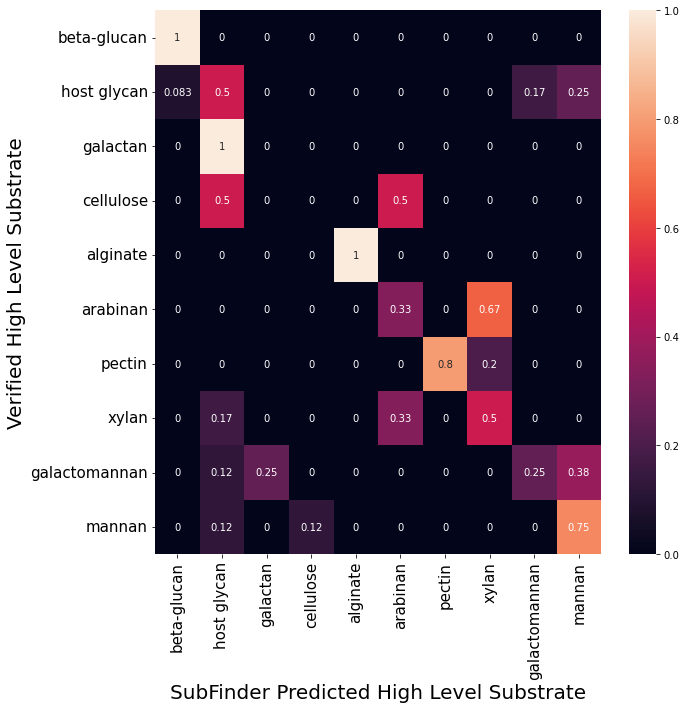

In [173]:
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15,  rotation = 0)
plt.ylabel("Verified High Level Substrate", fontsize = 20)
plt.xlabel("SubFinder Predicted High Level Substrate", fontsize = 20)
plt.show()

In [174]:
predicted_ifdp_subs = test_set["IFDP_Predicted_high_level_substr_dbcan_taxonomy"].values

In [175]:
actual_subs = test_set["Verified_high_level_substr"].values

In [176]:
common_order = set(actual_subs).union(predicted_ifdp_subs)

In [177]:
cm = confusion_matrix(actual_subs, predicted_ifdp_subs, normalize = "true", labels = list(common_order))

In [178]:
df_cm = pd.DataFrame(cm, index = list(common_order), columns= list(common_order))

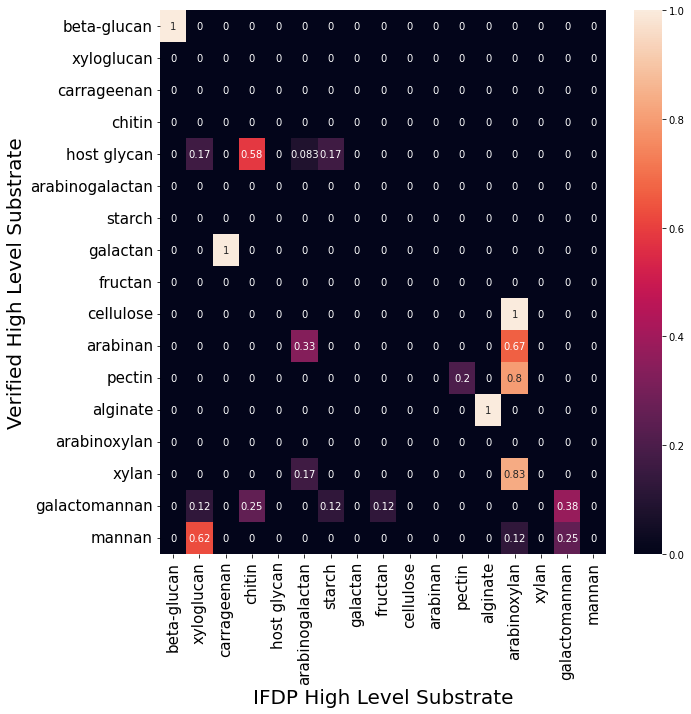

In [179]:
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15,  rotation = 0)
plt.ylabel("Verified High Level Substrate", fontsize = 20)
plt.xlabel("IFDP High Level Substrate", fontsize = 20)
plt.show()